# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import os 
%matplotlib inline

## Select tfrecord path for analysis
folder_name will be used to identify location to save image

In [2]:
folder_name = 'test' # 'train' 'val' 'test'
tfrecord_path = "data/"+folder_name+"/*.tfrecord"
dataset = get_dataset(tfrecord_path=tfrecord_path)


INFO:tensorflow:Reading unweighted datasets: ['data/test/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/test/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 10
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2022-05-27 16:07:12.330286: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


## function to display an image with the bounding boxes
Instances of different class are color coded, and flags provided in case want to output the images. 

In [3]:
def display_instances(instance,stats,display_sequence,img_prefix=folder_name,is_show_img=True,is_save_images=False,save_path=os.path.join(os.getcwd(),'summary_related')):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    # print(instance)
    name = instance['filename']
    img = instance['image'].numpy()
    img_shape = img.shape
    width = img_shape[1]
    height = img_shape[0]

    bboxes = instance['groundtruth_boxes'].numpy()
    classes = instance['groundtruth_classes'].numpy()

    # stats mapping
    obj_map = {}
    obj_map["1"] = "vehicle"
    obj_map["2"] = "pedestrian"
    obj_map["4"] = "cyclist"
    
    # if is_show_img:
    
    _,ax = plt.subplots(1,figsize=(10,10))
    # draw rectangles 
    for cl,bb in zip(classes,bboxes):
        box_x = int(bb[1]*width)
        box_y = int(bb[0]*height)
        box_w = int((bb[3]-bb[1])*width)
        box_h = int((bb[2]-bb[0])*height) 
        # print(box_x,box_y,box_w,box_h,cl,color_map[str(cl)])
        # record stats
        stats[obj_map[str(cl)]]+=1
        bbox_area = box_w * box_h
        stats["bbox_area"].append(bbox_area)
        # color mapping of the classes
        color_map = {}
        color_map['1'] = 'r' #vehicle
        color_map['2'] = 'g' #pedestrian
        color_map['4'] = 'b' #cyclist
        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor=color_map[str(cl)], facecolor='none')
        ax.add_patch(rect)
        # print(name,'img_shape ',img_shape)
    imgplot = plt.imshow(img)
    # plt.show()
    image_name = img_prefix+'_'+str(display_sequence)+'.png'
    plt.savefig(os.path.join(save_path,image_name))
    
    # ADD CODE HERE

## Function to display some stats 

This function will record each classes instance occurances and their label areas ,it will output a plot to show the precentages of the distribution 

In [4]:
# show stats 
def display_stats(stats):
    plt.figure(figsize=(20,20))

    # plot for label distribution 
    plt.subplot(3,1,1)
    labels='vehicle','pedestrian','cyclist'
    colors = ['gold', 'yellowgreen', 'lightcoral']
    sizes = [stats["vehicle"],stats["pedestrian"],stats["cyclist"]]
    plt.pie(sizes,labels=labels,autopct='%1.1f%%',colors=colors,shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('label_percentatge')
    plt.show()

    # plot for area histogram distribution 
    plt.figure(figsize=(20,20))
    plt.subplot(3,1,2)
    plt.hist(stats["bbox_area"],density=True,bins=100)
    plt.ylabel('percentatge')
    plt.xlabel('bbox_area')
    plt.show()
    # plot for label size distribution
    plt.figure(figsize=(20,20))
    plt.subplot(3,1,3)
    for each in stats["bbox_area"]:
        if each > 96*96:
            stats["coco_area_metrics"]["large"]+=1
        elif each < 32*32:
            stats["coco_area_metrics"]["small"]+=1
        else:
            stats["coco_area_metrics"]["medium"]+=1
    print(stats["coco_area_metrics"])
    labels='large','medium','small'
    colors = ['gold', 'yellowgreen', 'lightcoral']
    sizes = [stats["coco_area_metrics"]["large"],stats["coco_area_metrics"]["medium"],stats["coco_area_metrics"]["small"]]
    plt.pie(sizes,labels=labels,autopct='%1.1f%%',colors=colors,shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('coco_area_metric_percentatge')
    plt.show()

## Main function to call display image and display stat
Note : since dataset take method is randomly select images and shuffle the rest, more images selected to show will provide a better understanding of the dataset label distribution

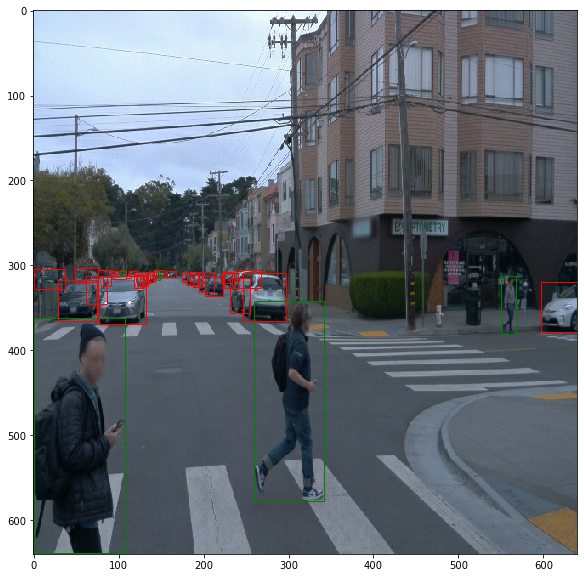

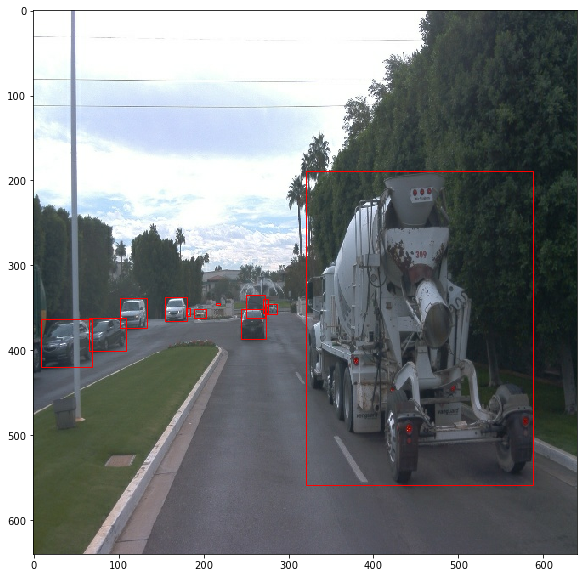

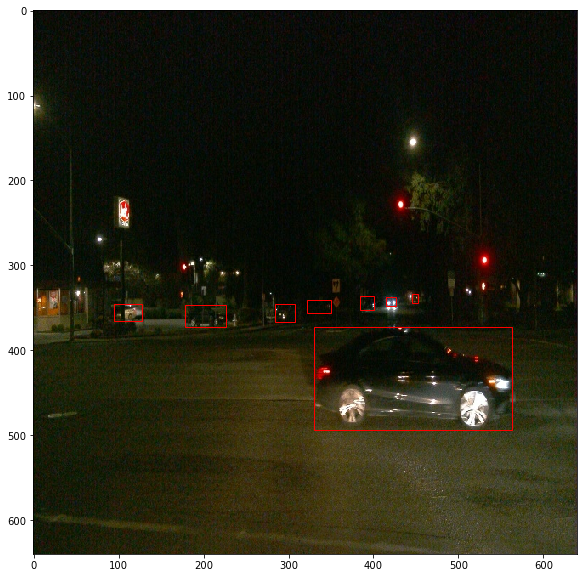

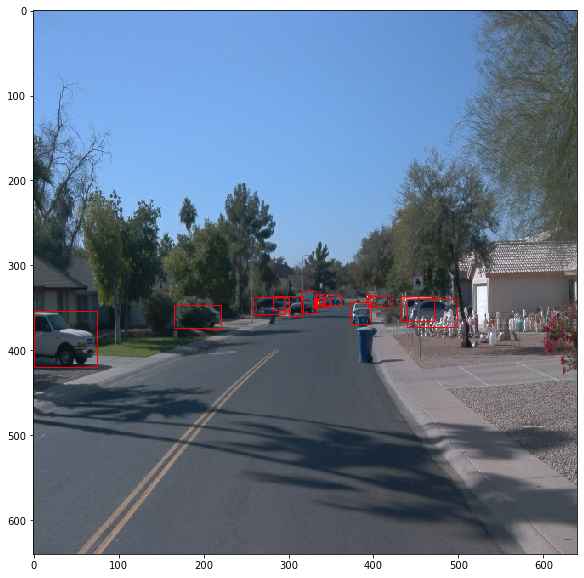

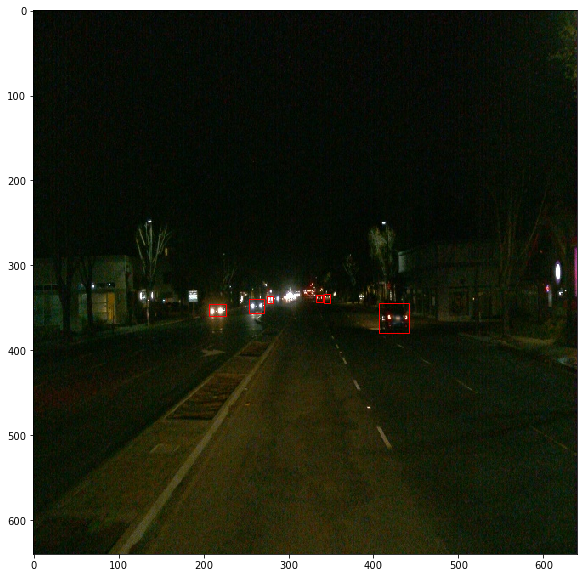

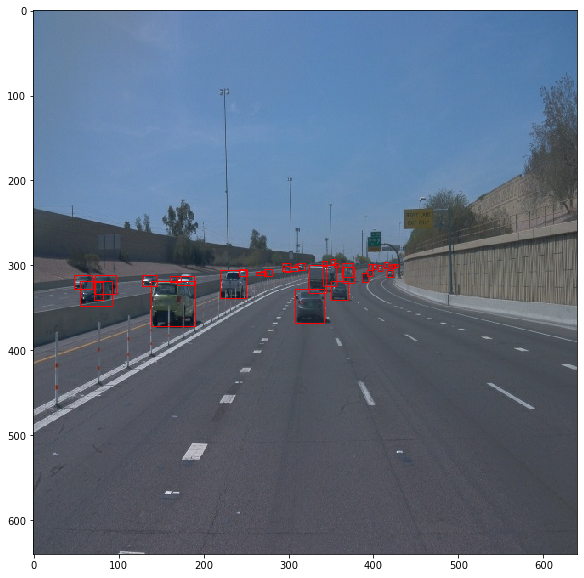

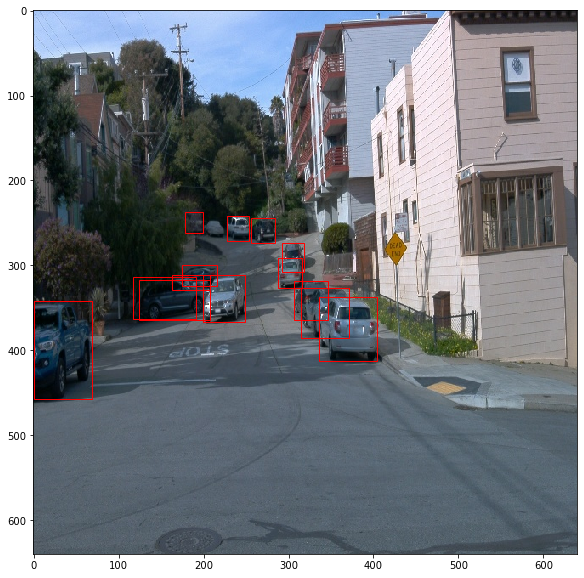

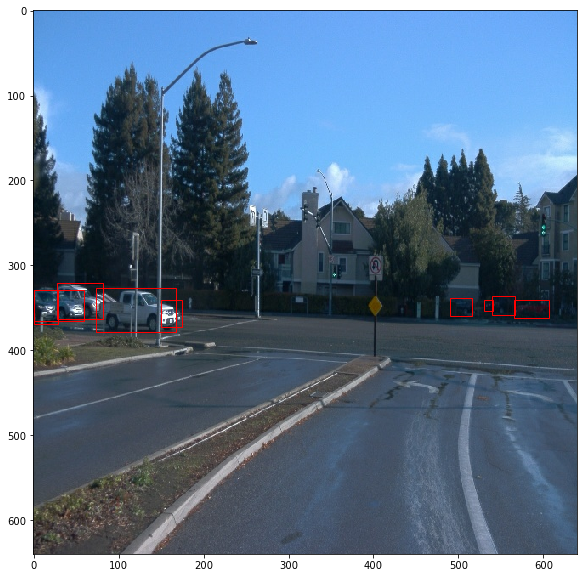

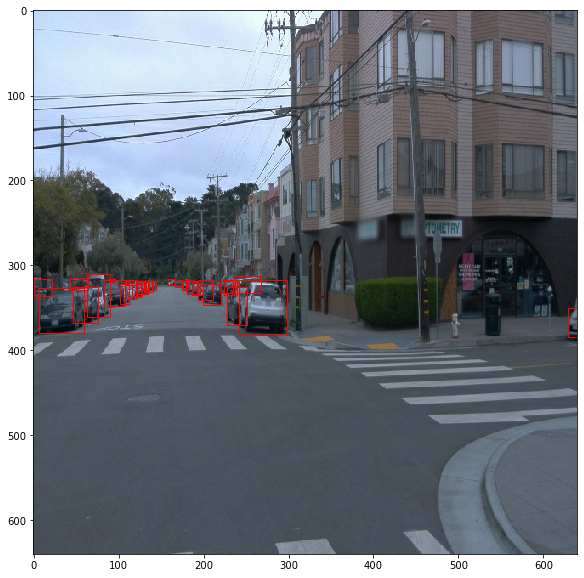

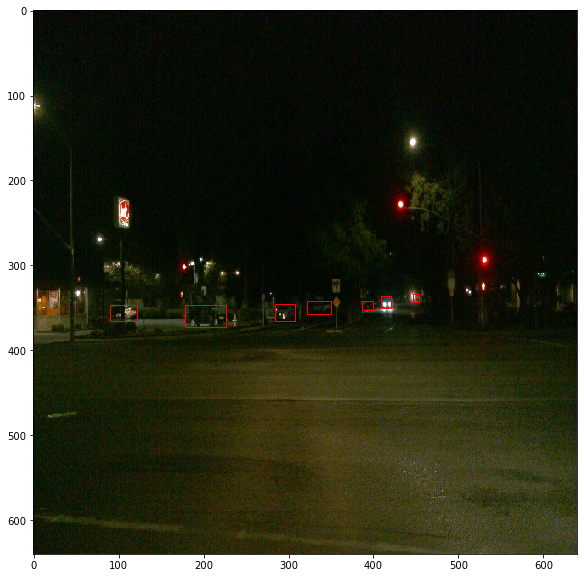

In [5]:
## some flags to set 
ds_batched = dataset
is_show_stats = False
num_img_to_show =10 # use a substantially large number if need to show stats, but Note, it will take a while
# build dictionary to record some stats
# record instances occurances 
stats = {}
stats["vehicle"] = 0
stats["pedestrian"] = 0
stats["cyclist"] = 0
# coco api 
# large: area>96**2 square pix 
# medium: 32**2<area<96**2 square pix
# small: area<32**2
# record instance area and group per coco api rules
stats["bbox_area"] = []
stats["coco_area_metrics"] = {'large':0,'medium':0,'small':0}
i = 0
for instance in ds_batched.take(num_img_to_show):
    i+=1
    # print(i)
    display_instances(instance,stats,display_sequence=i,is_show_img=True,is_save_images=True)
if is_show_stats:    
    display_stats(stats)

